# Pocket Visualization with PyMOL Scripts

This notebook helps you visualize true and predicted pockets using PyMOL rendering scripts generated during evaluation.

**Pipeline Output Location:** `outputs/p2rank_like_run_test/`

**Key Metrics from Latest Run:**
- Total proteins evaluated: 108
- DCC Success@1: 43.7% (distance from centre to centre < 4Å)
- DCA Success@1: 75.3% (distance to nearest atom < 4Å)
- Mean IoU: 0.192
- Best IoU: 0.234

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import Image, display
import subprocess
import os

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Load Per-Protein Metrics

First, let's load the metrics to understand which proteins performed well or poorly.

In [2]:
# Paths
base_path = Path('/system/user/studentwork/hageneder/MSC/Practical_work/PockNet/outputs/p2rank_like_run_test')
metrics_path = base_path / 'summary' / 'per_protein_metrics.csv'
viz_path = base_path / 'visualizations'
pymol_scripts_path = viz_path / 'pymol_scripts'

# Load metrics
df = pd.read_csv(metrics_path)

print(f"Total proteins: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few entries:")
df.head(10)

Total proteins: 108

Columns: ['protein_id', 'n_points', 'n_pockets_total', 'n_pockets_eval', 'max_score', 'max_score_eval', 'sum_scores_total', 'sum_scores_eval', 'mean_gt_iou_default', 'best_iou', 'gt_coverage']

First few entries:


protein_id  n_points  n_pockets_total  n_pockets_eval   max_score  \
0     1a4j_H      5938                2               2  105.916992   
1     1a4j_L      5798                3               3   34.187130   
2     1a6u_H      3020                3               3  144.884491   
3     1a6u_L      2723                1               1  110.191307   
4     1a6w_H      3082                1               1  193.883926   
5     1a6w_L      2715                1               1   94.190384   
6     1acj_A     10587                1               1   45.778511   
7     1ahc_A      6474                1               1   84.472069   
8     1apu_E      7448                4               4  393.937317   
9     1bbs_A      7960                6               6   56.410488   

   max_score_eval  sum_scores_total  sum_scores_eval  mean_gt_iou_default  \
0      105.916992        134.897505       134.897505             0.597403   
1       34.187130         71.792727        71.792727             0.167964   
2      144.884491        186.133411       186.133411             0.191571   
3      110.191307        110.191307       110.191307             0.067130   
4      193.883926        193.883926       193.883926             0.151335   
5       94.190384         94.190384        94.190384             0.063452   
6       45.778511         45.778511        45.778511             0.029304   
7       84.472069         84.472069        84.472069             0.213542   
8      393.937317        692.555048       692.555048             0.260870   
9       56.410488        118.474584       118.474584             0.090132   

   best_iou  gt_coverage  
0  0.597403     1.000000  
1  0.206897     1.000000  
2  0.191571     1.000000  
3  0.120370     1.000000  
4  0.151335     1.000000  
5  0.111675     1.000000  
6  0.087912     0.333333  
7  0.213542     1.000000  
8  0.260870     1.000000  
9  0.179487     0.666667

## 2. Explore Metrics Distribution


=== Summary Statistics ===
         best_iou  mean_gt_iou_default  gt_coverage
count  108.000000           108.000000   108.000000
mean     0.234309             0.192066     0.862654
std      0.158996             0.123130     0.324516
min      0.000000             0.000000     0.000000
25%      0.127453             0.099186     1.000000
50%      0.227335             0.195088     1.000000
75%      0.299096             0.261442     1.000000
max      0.775316             0.597403     1.000000


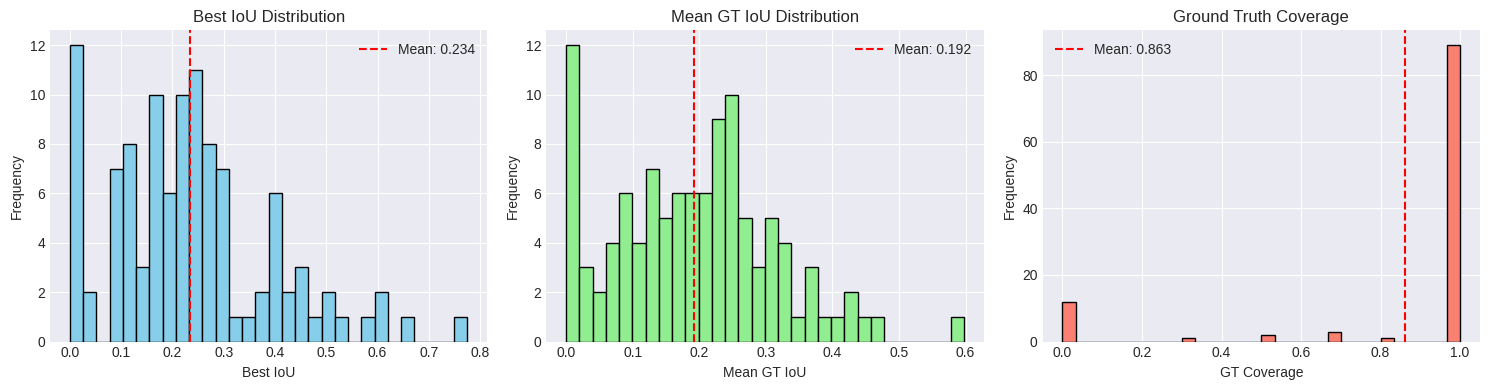

In [3]:
# Summary statistics
print("\n=== Summary Statistics ===")
print(df[['best_iou', 'mean_gt_iou_default', 'gt_coverage']].describe())

# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df['best_iou'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Best IoU')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Best IoU Distribution')
axes[0].axvline(df['best_iou'].mean(), color='red', linestyle='--', label=f'Mean: {df["best_iou"].mean():.3f}')
axes[0].legend()

axes[1].hist(df['mean_gt_iou_default'], bins=30, color='lightgreen', edgecolor='black')
axes[1].set_xlabel('Mean GT IoU')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Mean GT IoU Distribution')
axes[1].axvline(df['mean_gt_iou_default'].mean(), color='red', linestyle='--', label=f'Mean: {df["mean_gt_iou_default"].mean():.3f}')
axes[1].legend()

axes[2].hist(df['gt_coverage'], bins=30, color='salmon', edgecolor='black')
axes[2].set_xlabel('GT Coverage')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Ground Truth Coverage')
axes[2].axvline(df['gt_coverage'].mean(), color='red', linestyle='--', label=f'Mean: {df["gt_coverage"].mean():.3f}')
axes[2].legend()

plt.tight_layout()
plt.show()

## 3. Select Proteins for Visualization

Let's identify interesting cases:
- **Success cases** (high IoU)
- **Moderate cases** (medium IoU)
- **Failure cases** (low IoU)

In [4]:
# Sort by best IoU
df_sorted = df.sort_values('best_iou', ascending=False)

print("\n=== TOP 10 Best Performers (High IoU) ===")
top_10 = df_sorted.head(10)[['protein_id', 'best_iou', 'mean_gt_iou_default', 'gt_coverage', 'n_pockets_eval']]
print(top_10.to_string(index=False))

print("\n=== BOTTOM 10 Worst Performers (Low IoU) ===")
bottom_10 = df_sorted.tail(10)[['protein_id', 'best_iou', 'mean_gt_iou_default', 'gt_coverage', 'n_pockets_eval']]
print(bottom_10.to_string(index=False))

print("\n=== MODERATE Cases (Around median IoU) ===")
median_iou = df['best_iou'].median()
df['iou_diff_from_median'] = abs(df['best_iou'] - median_iou)
moderate_cases = df.nsmallest(10, 'iou_diff_from_median')[['protein_id', 'best_iou', 'mean_gt_iou_default', 'gt_coverage', 'n_pockets_eval']]
print(moderate_cases.to_string(index=False))


=== TOP 10 Best Performers (High IoU) ===
protein_id  best_iou  mean_gt_iou_default  gt_coverage  n_pockets_eval
    1nna_A  0.775316             0.337593     1.000000              12
    1qpe_A  0.666667             0.275218     0.666667               3
    2ctb_A  0.600000             0.230303     1.000000               4
    1a4j_H  0.597403             0.597403     1.000000               2
    1inc_A  0.571429             0.373120     1.000000               3
    1phd_A  0.529412             0.402661     1.000000               5
    1qif_A  0.500000             0.319307     1.000000               2
    1rne_A  0.500000             0.257724     0.666667               3
    1ivd_A  0.465517             0.247101     0.833333              19
    1phc_A  0.461538             0.461538     1.000000               4

=== BOTTOM 10 Worst Performers (Low IoU) ===
protein_id  best_iou  mean_gt_iou_default  gt_coverage  n_pockets_eval
    1gcg_A       0.0                  0.0          0.0     

## 4. Display Pre-rendered PyMOL Images

The pipeline has already generated PNG images for each protein. Let's display them!


🎯 SUCCESS CASE - Highest IoU

Protein: 1nna_A
Best IoU:          0.7753
Mean GT IoU:       0.3376
GT Coverage:       1.0000
# Pockets:         12
Max Pocket Score:  547.87



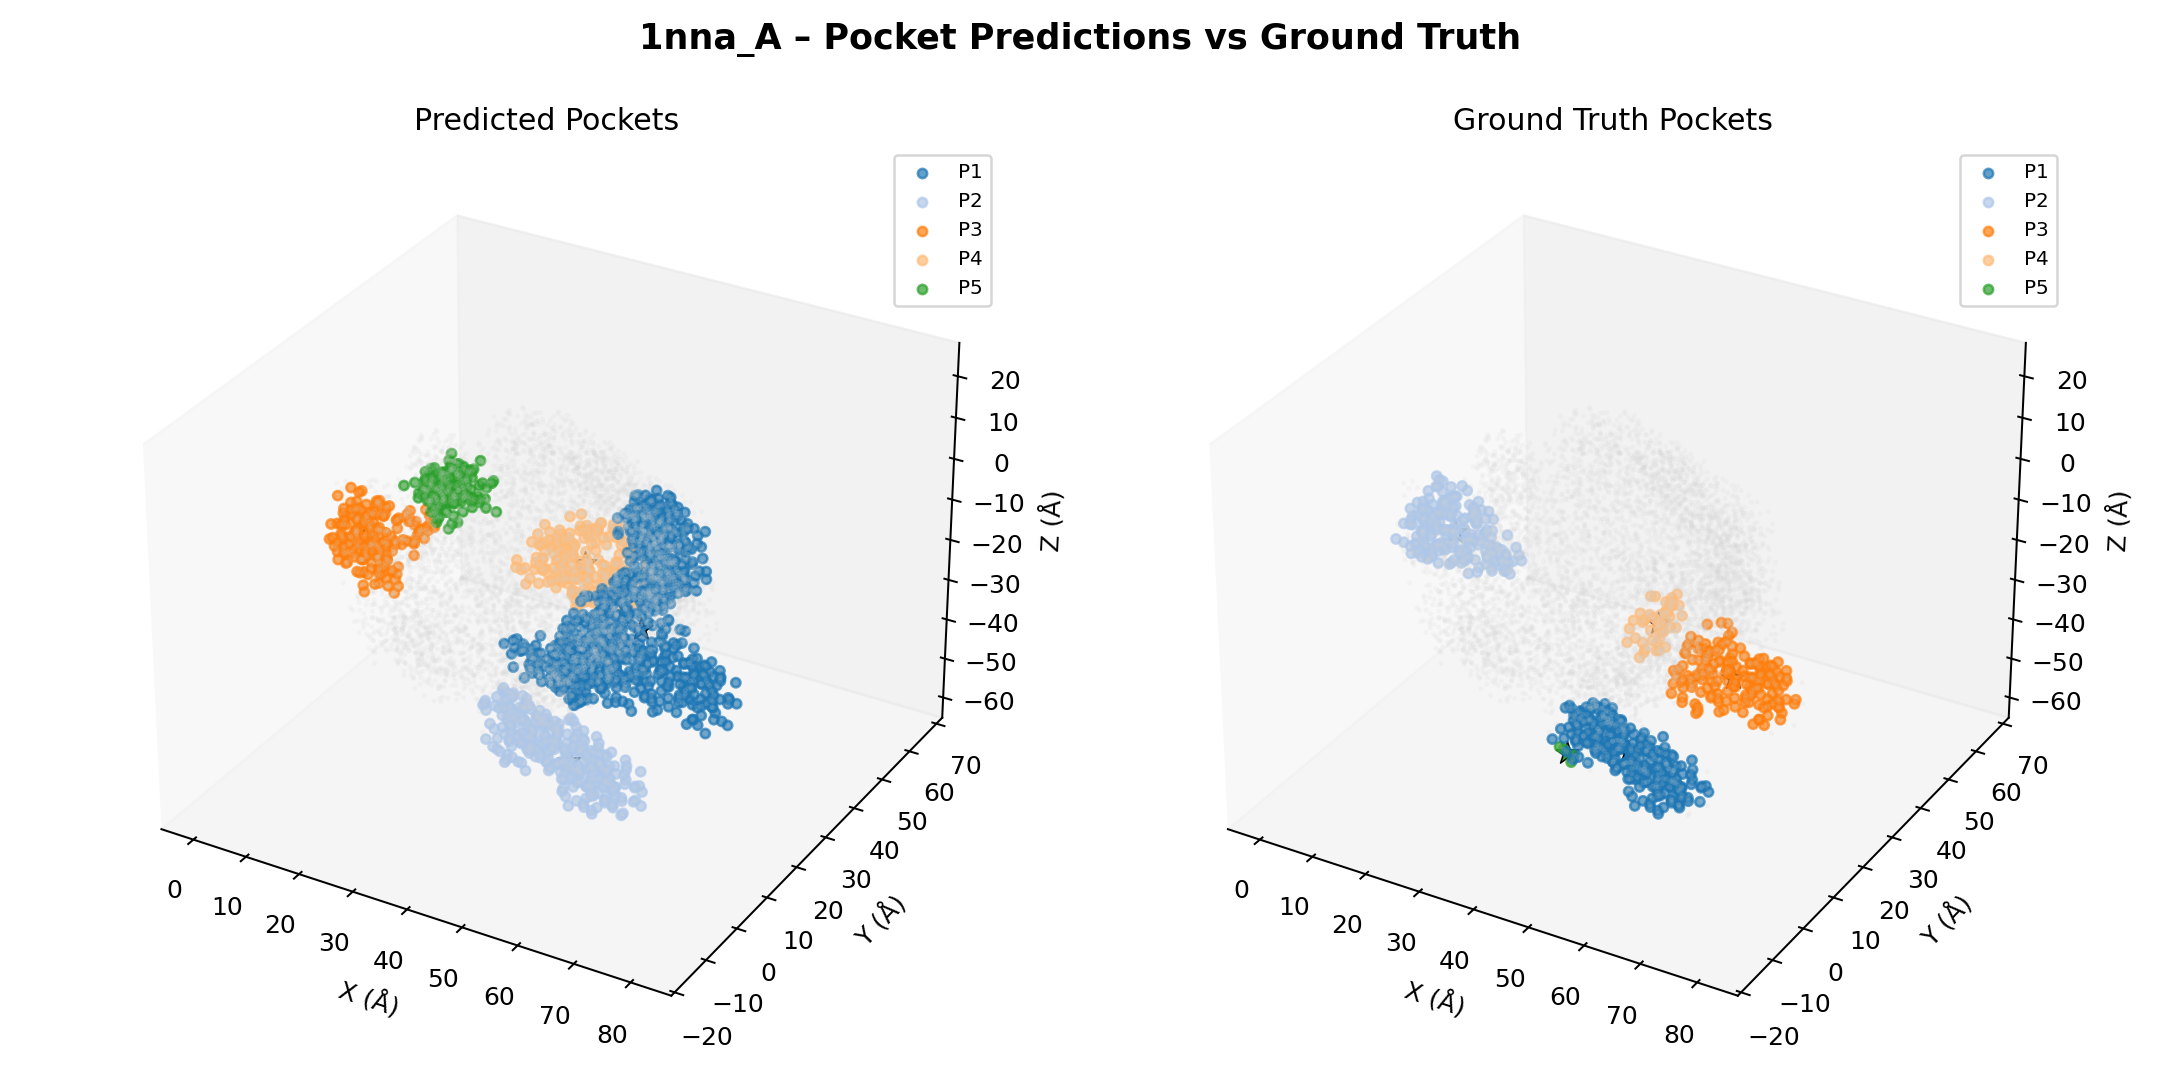

In [5]:
def display_protein_visualization(protein_id, metrics_df=None):
    """
    Display pre-rendered PyMOL image for a protein with metrics.
    
    Args:
        protein_id: PDB ID with chain (e.g., '1cge_A')
        metrics_df: DataFrame with protein metrics (optional)
    """
    img_path = viz_path / f"{protein_id}_pockets.png"
    
    if not img_path.exists():
        print(f"❌ Image not found: {img_path}")
        return
    
    # Display metrics if available
    if metrics_df is not None:
        protein_metrics = metrics_df[metrics_df['protein_id'] == protein_id]
        if not protein_metrics.empty:
            row = protein_metrics.iloc[0]
            print(f"\n{'='*60}")
            print(f"Protein: {protein_id}")
            print(f"{'='*60}")
            print(f"Best IoU:          {row['best_iou']:.4f}")
            print(f"Mean GT IoU:       {row['mean_gt_iou_default']:.4f}")
            print(f"GT Coverage:       {row['gt_coverage']:.4f}")
            print(f"# Pockets:         {int(row['n_pockets_eval'])}")
            print(f"Max Pocket Score:  {row['max_score_eval']:.2f}")
            print(f"{'='*60}\n")
    
    # Display image
    display(Image(filename=str(img_path)))

# Example: Display top success case
print("\n🎯 SUCCESS CASE - Highest IoU")
best_protein = df_sorted.iloc[0]['protein_id']
display_protein_visualization(best_protein, df)

## 5. Compare Multiple Cases Side-by-Side


📊 COMPARISON: Success vs Moderate vs Failure


🟢 SUCCESS: 1nna_A

Protein: 1nna_A
Best IoU:          0.7753
Mean GT IoU:       0.3376
GT Coverage:       1.0000
# Pockets:         12
Max Pocket Score:  547.87



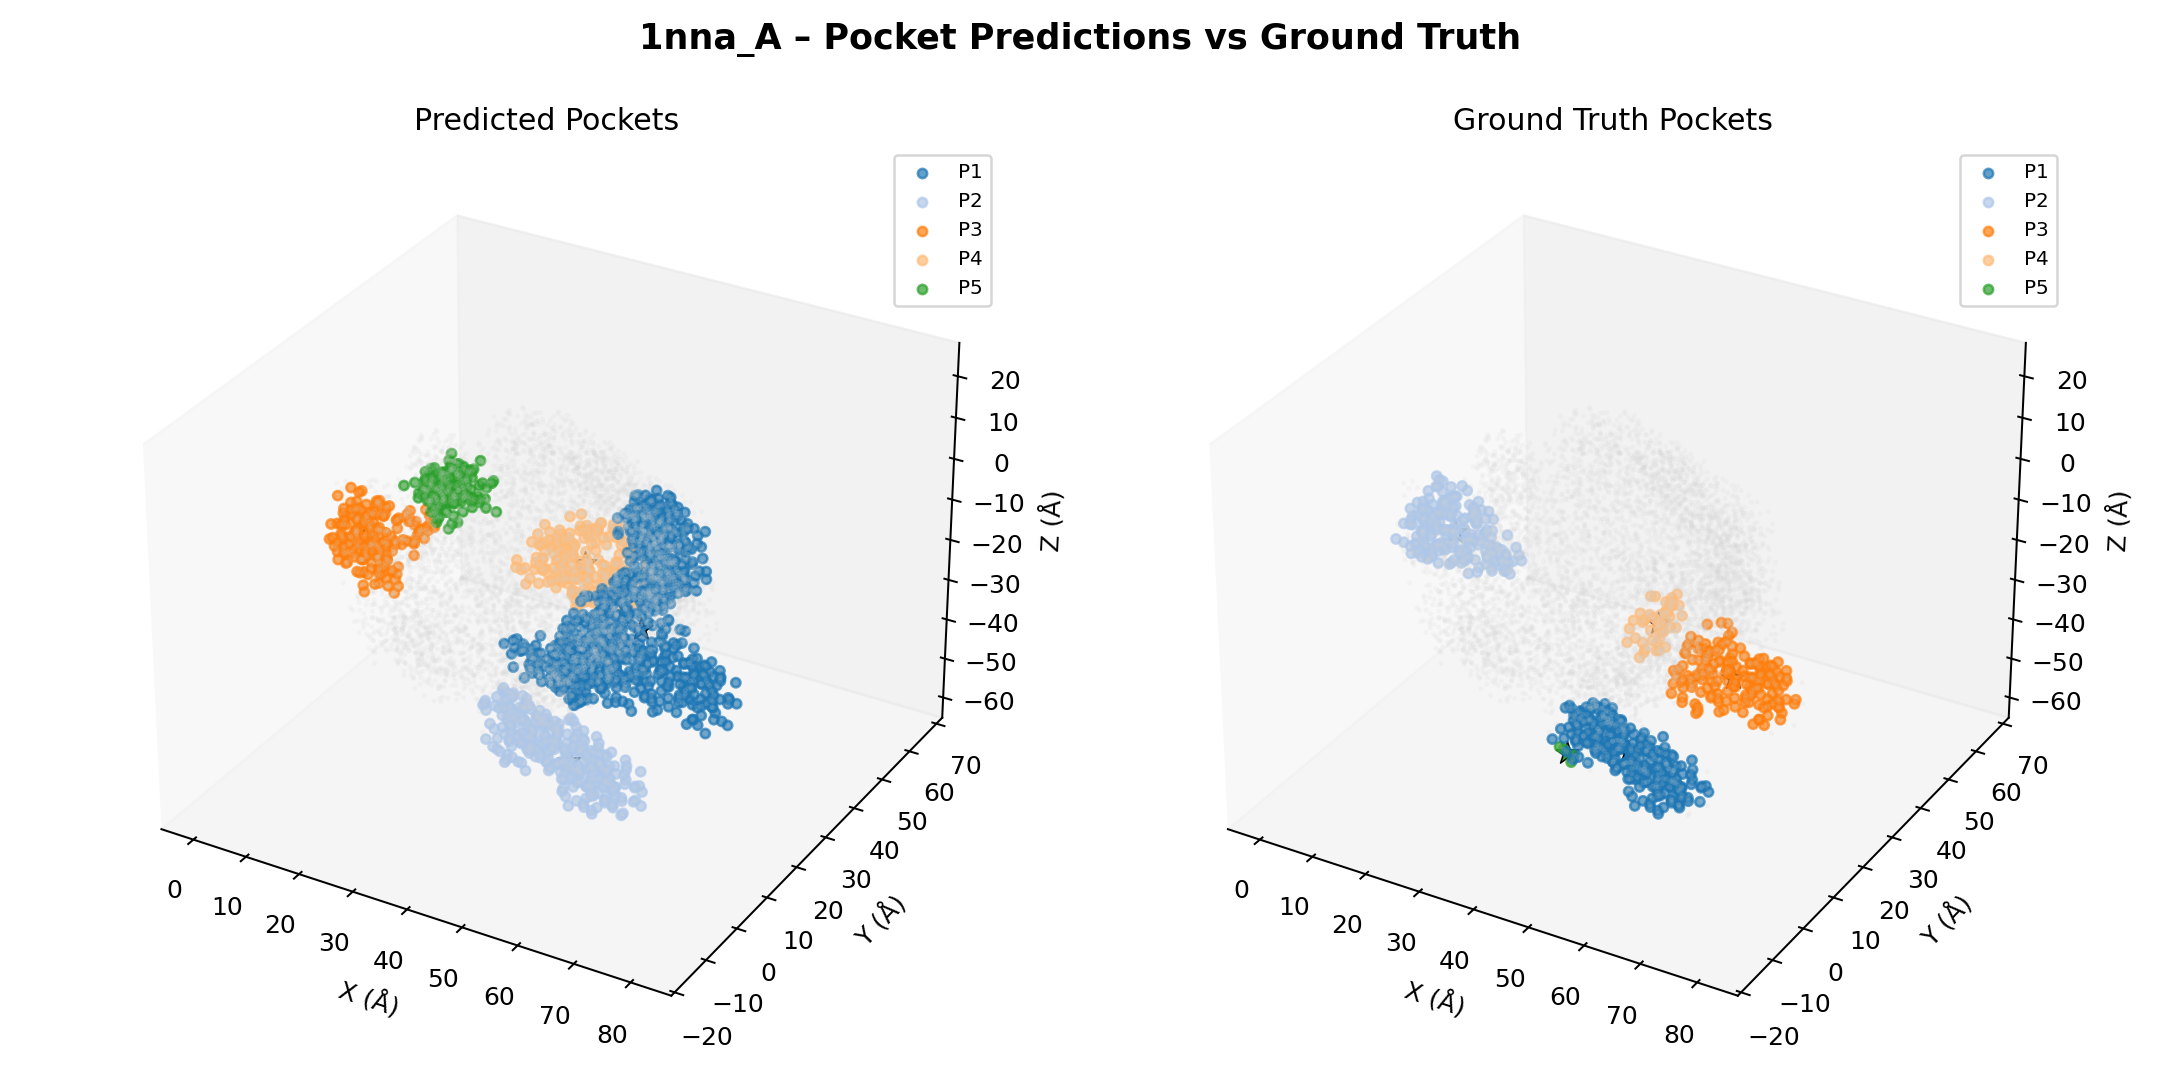


🟡 MODERATE: 1chg_A

Protein: 1chg_A
Best IoU:          0.2274
Mean GT IoU:       0.2274
GT Coverage:       1.0000
# Pockets:         2
Max Pocket Score:  192.78



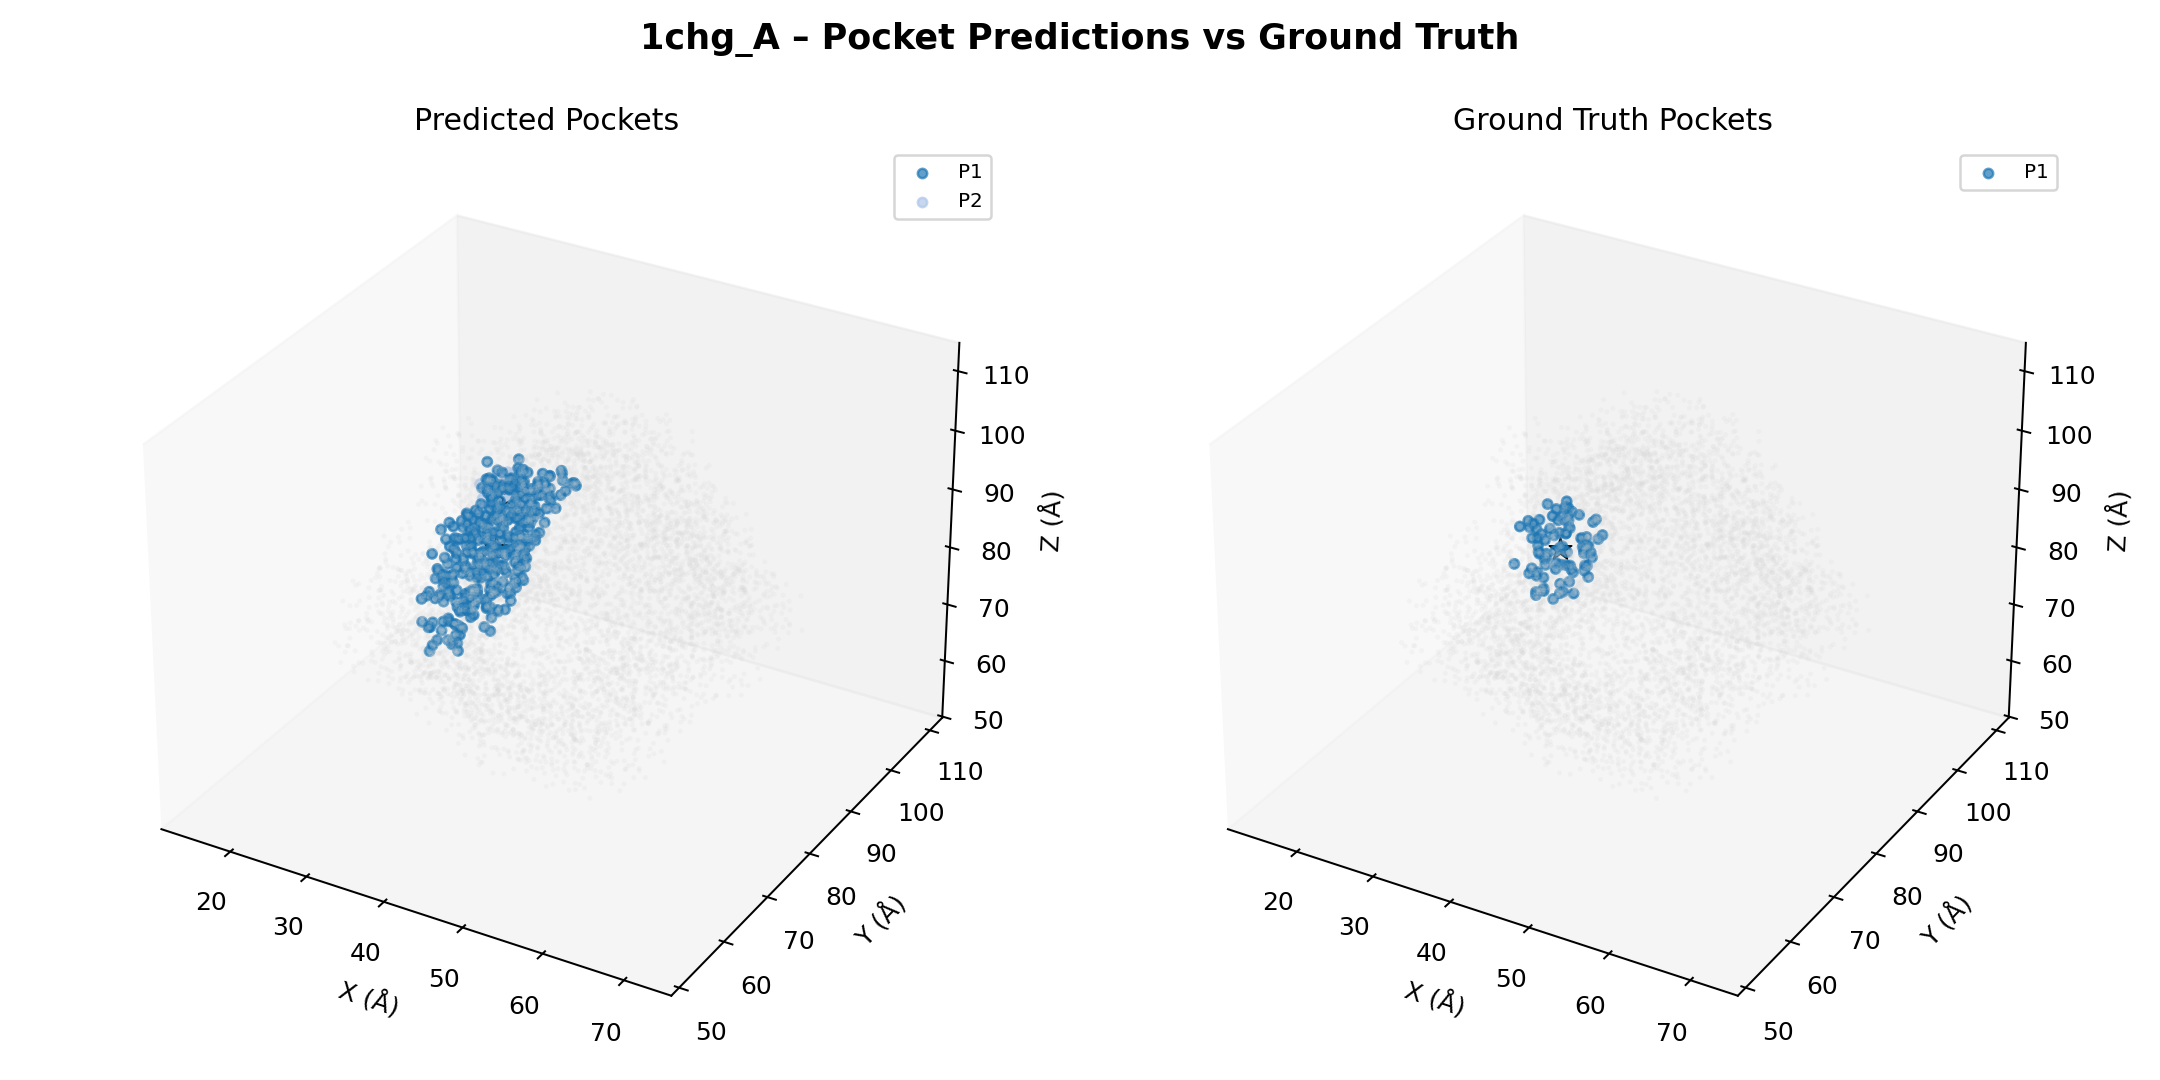


🔴 FAILURE: 3mth_C

Protein: 3mth_C
Best IoU:          0.0000
Mean GT IoU:       0.0000
GT Coverage:       0.0000
# Pockets:         1
Max Pocket Score:  13.21



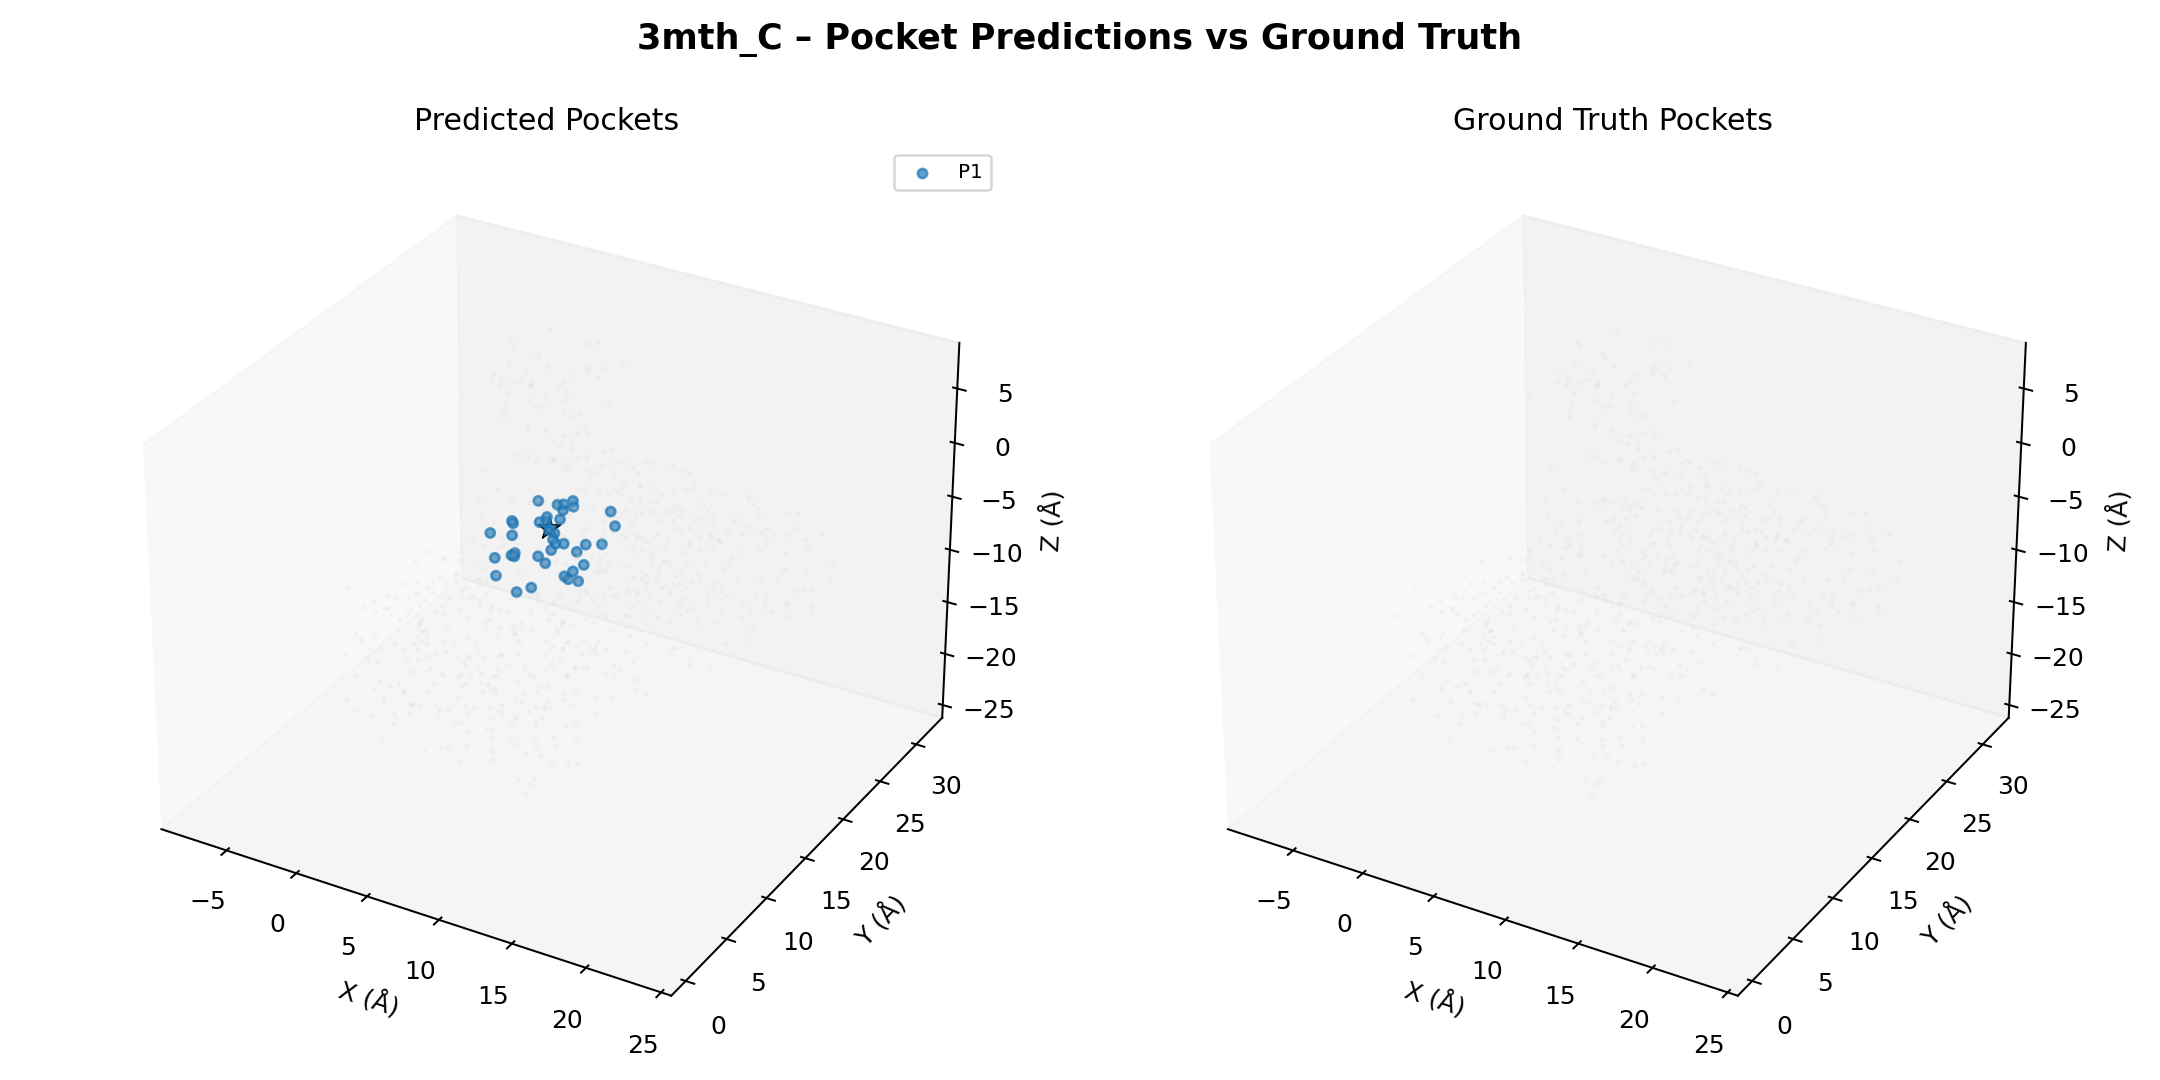

In [6]:
# Select representative cases
best_case = df_sorted.iloc[0]['protein_id']
moderate_case = df.nsmallest(1, 'iou_diff_from_median').iloc[0]['protein_id']
worst_case = df_sorted.iloc[-1]['protein_id']

print("\n📊 COMPARISON: Success vs Moderate vs Failure\n")

for label, protein_id in [("🟢 SUCCESS", best_case), ("🟡 MODERATE", moderate_case), ("🔴 FAILURE", worst_case)]:
    print(f"\n{label}: {protein_id}")
    display_protein_visualization(protein_id, df)

## 6. Interactive Protein Selection

Choose any protein from the dataset to visualize:

In [7]:
# List all available proteins
print("\n📋 Available Proteins (sorted by IoU):")
print("="*60)
for idx, row in df_sorted[['protein_id', 'best_iou', 'n_pockets_eval']].iterrows():
    print(f"{row['protein_id']:12s} | IoU: {row['best_iou']:.4f} | Pockets: {int(row['n_pockets_eval'])}")

print("\n💡 Copy a protein_id from above and paste below:")


📋 Available Proteins (sorted by IoU):
1nna_A       | IoU: 0.7753 | Pockets: 12
1qpe_A       | IoU: 0.6667 | Pockets: 3
2ctb_A       | IoU: 0.6000 | Pockets: 4
1a4j_H       | IoU: 0.5974 | Pockets: 2
1inc_A       | IoU: 0.5714 | Pockets: 3
1phd_A       | IoU: 0.5294 | Pockets: 5
1qif_A       | IoU: 0.5000 | Pockets: 2
1rne_A       | IoU: 0.5000 | Pockets: 3
1ivd_A       | IoU: 0.4655 | Pockets: 19
1phc_A       | IoU: 0.4615 | Pockets: 4
3gch_A       | IoU: 0.4615 | Pockets: 3
1psn_A       | IoU: 0.4569 | Pockets: 1
1hew_A       | IoU: 0.4301 | Pockets: 2
1hel_A       | IoU: 0.4255 | Pockets: 2
1mtw_A       | IoU: 0.4121 | Pockets: 1
1mrg_A       | IoU: 0.4118 | Pockets: 4
2tga_A       | IoU: 0.4040 | Pockets: 1
5cpa_A       | IoU: 0.3929 | Pockets: 2
1bya_A       | IoU: 0.3897 | Pockets: 1
1igj_B       | IoU: 0.3889 | Pockets: 1
7cpa_A       | IoU: 0.3762 | Pockets: 1
1hsi_A       | IoU: 0.3701 | Pockets: 3
1snc_A       | IoU: 0.3538 | Pockets: 2
1stn_A       | IoU: 0.3327 | Pockets: 2


🔍 Visualizing: 1cge_A

Protein: 1cge_A
Best IoU:          0.3071
Mean GT IoU:       0.3071
GT Coverage:       1.0000
# Pockets:         4
Max Pocket Score:  214.46



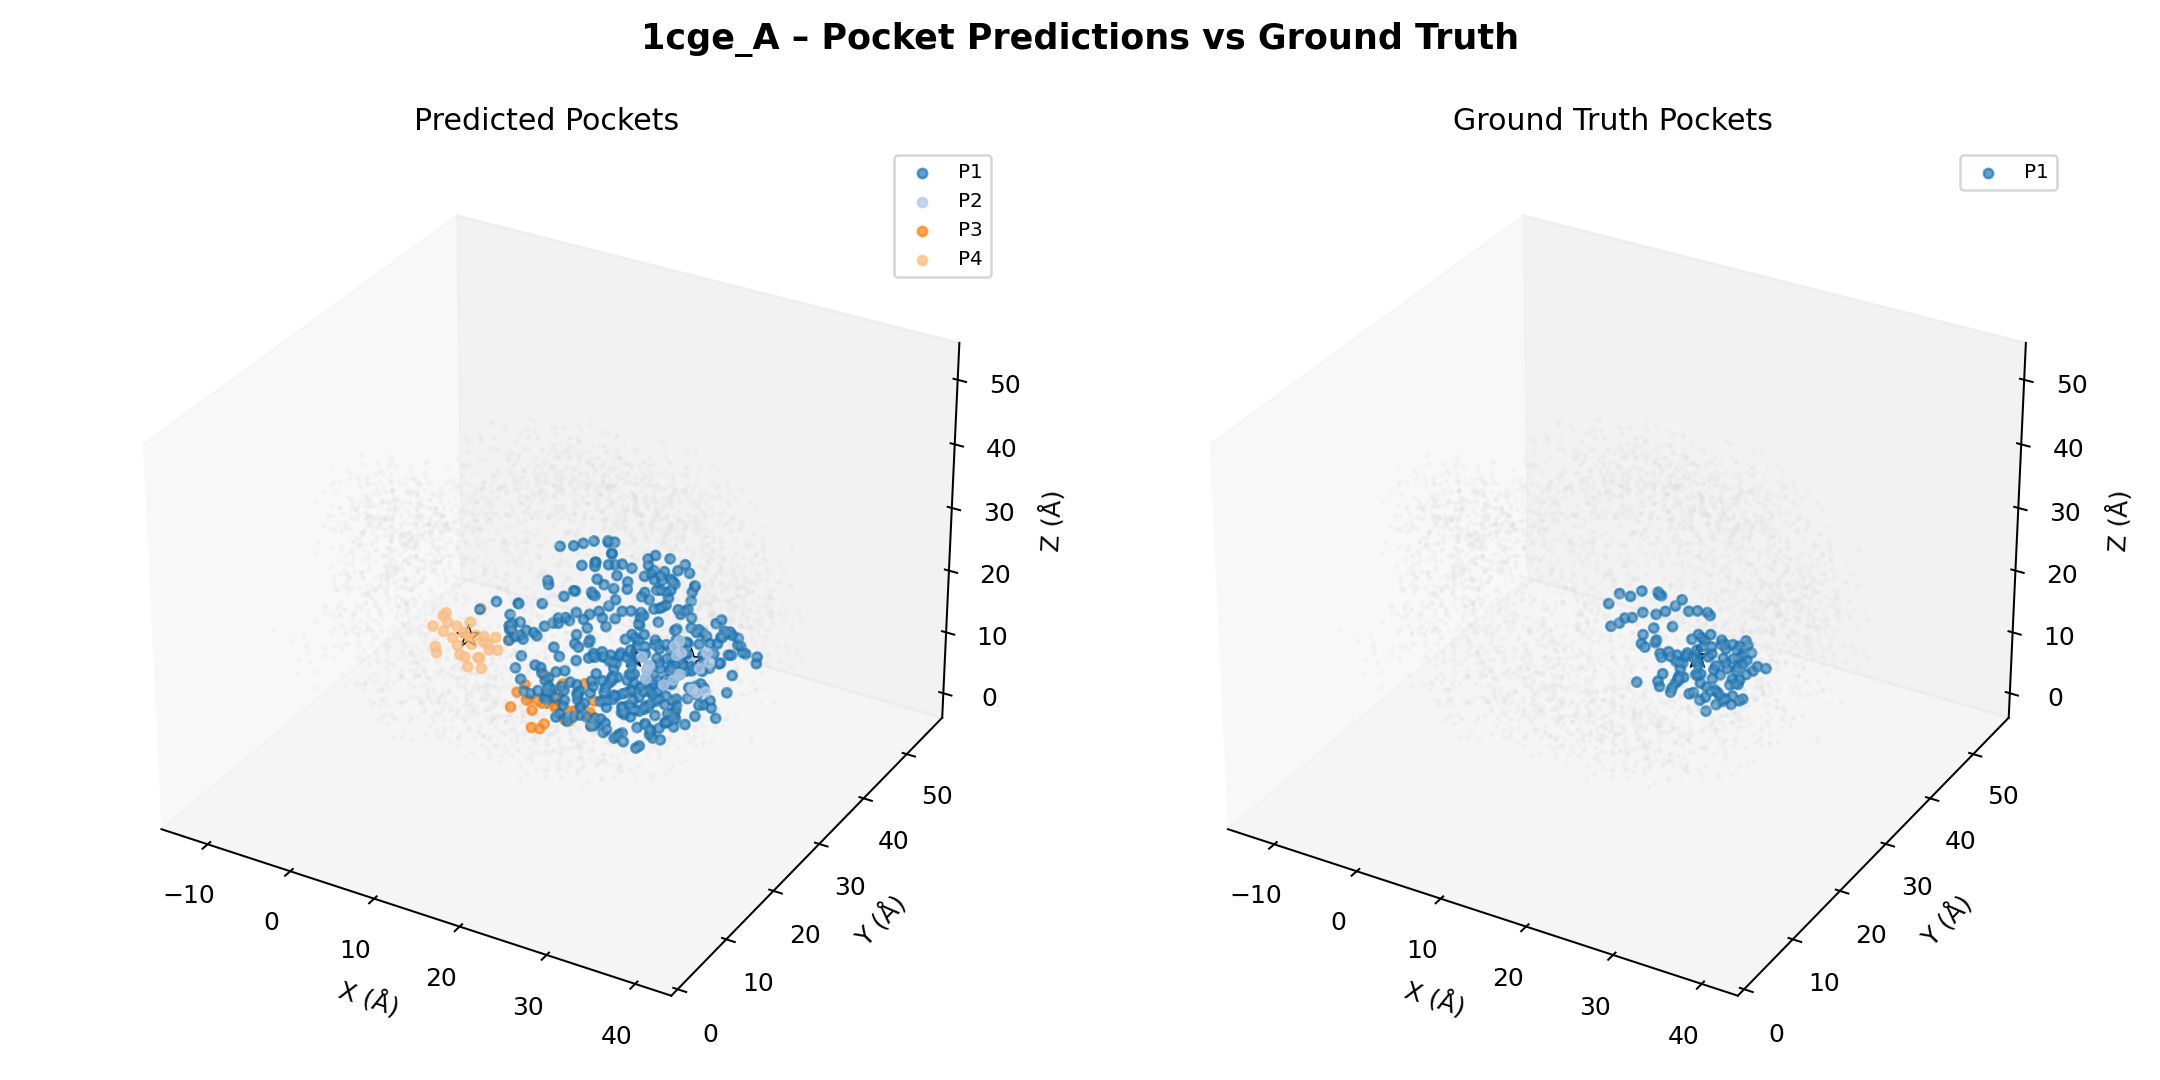

In [8]:
# Manually select a protein
selected_protein = "1cge_A"  # 👈 Change this to any protein ID

print(f"\n🔍 Visualizing: {selected_protein}")
display_protein_visualization(selected_protein, df)

## 7. Render High-Quality Image with PyMOL - Practical Work Style

Match the visual style from your practical work with light blue surface points and transparent protein surface:

In [9]:
def render_practical_work_style(protein_id, output_path=None, ray_trace=True, width=2400, height=2400,
                                  show_sas_background=True, show_protein_surface=True):
    """
    Render protein with pockets using practical work visual style:
    - Light blue/cyan surface points (SAS background)
    - Transparent protein surface
    - Cartoon representation
    - Green ground truth pockets
    - Yellow/orange predicted pockets
    - White background
    
    Args:
        protein_id: PDB ID with chain (e.g., '1cge_A')
        output_path: Output PNG path (default: current dir)
        ray_trace: Use ray tracing for high quality (slower)
        width, height: Image dimensions
        show_sas_background: Show the light blue surface points
        show_protein_surface: Show the transparent protein surface
    """
    script_path = pymol_scripts_path / f"{protein_id}_pockets.pml"
    
    if not script_path.exists():
        print(f"❌ PyMOL script not found: {script_path}")
        return None
    
    if output_path is None:
        output_path = Path.cwd() / f"{protein_id}_practical_style.png"
    
    # Create custom PyMOL script matching practical work style
    custom_script = f"""
# Load original script
cd {pymol_scripts_path}
run {script_path.name}

# === PRACTICAL WORK STYLE SETTINGS ===

# Background and basic settings
bg_color white
set ray_shadows, 0
set antialias, 2
set depth_cue, 0

# Define custom colors matching practical work
set_color light_blue, [0.6, 0.8, 1.0]      # Light blue for surface points
set_color cyan_blue, [0.5, 0.85, 0.95]     # Cyan blue alternative
set_color dark_green, [0.0, 0.6, 0.0]      # Dark green for GT pockets
set_color bright_yellow, [1.0, 0.9, 0.0]   # Bright yellow for predictions
set_color transparent_gray, [0.7, 0.7, 0.7] # Gray for protein surface

# === PROTEIN STYLING ===
# Show protein as cartoon with transparent surface
show cartoon, protein
{"show surface, protein" if show_protein_surface else "hide surface, protein"}
set cartoon_fancy_helices, 1
set cartoon_smooth_loops, 1
color gray70, protein
set surface_color, transparent_gray, protein
set transparency, 0.5, protein

# === SURFACE POINTS (SAS BACKGROUND) ===
# Style the light blue surface points like in practical work
{"show spheres, sas_background" if show_sas_background else "hide spheres, sas_background"}
set sphere_scale, 0.3, sas_background
color light_blue, sas_background
set transparency, 0.0, sas_background

# === GROUND TRUTH POCKETS ===
# Style GT pockets with dark green color
show spheres, GT_pocket*
set sphere_scale, 0.7, GT_pocket*
color dark_green, GT_pocket*
set transparency, 0.2, GT_pocket*

# === PREDICTED POCKETS ===
# Style predicted pockets with bright yellow/orange
show spheres, pred_pocket*
set sphere_scale, 0.7, pred_pocket*
color bright_yellow, pred_pocket*
set transparency, 0.3, pred_pocket*

# === RENDERING SETTINGS ===
set specular, 1
set surface_quality, 2
set ray_trace_mode, 1
set ray_trace_gain, 0.1

# Center and zoom
zoom all
orient

# Render
{'ray ' + str(width) + ',' + str(height) if ray_trace else 'draw'}
png {output_path}, dpi=300
quit
"""
    
    temp_script = Path("/tmp") / f"pymol_practical_{protein_id}.pml"
    temp_script.write_text(custom_script)
    
    print(f"🎨 Rendering {protein_id} with Practical Work style...")
    print(f"   Settings: {width}x{height}, ray_trace={ray_trace}")
    print(f"   Style: Light blue surface points, transparent protein")
    
    try:
        # Run PyMOL in command-line mode
        result = subprocess.run(
            ["pymol", "-c", "-u", str(temp_script)],
            capture_output=True,
            text=True,
            timeout=120
        )
        
        if result.returncode == 0 and Path(output_path).exists():
            print(f"✅ Rendering complete: {output_path}")
            print(f"   File size: {Path(output_path).stat().st_size / 1024 / 1024:.2f} MB")
            return output_path
        else:
            print(f"❌ Rendering failed")
            print(f"   stdout: {result.stdout}")
            print(f"   stderr: {result.stderr}")
            return None
    except subprocess.TimeoutExpired:
        print("⏱️ Rendering timeout (>120s)")
        return None
    except FileNotFoundError:
        print("❌ PyMOL not found. Install with: conda install -c conda-forge pymol-open-source")
        return None
    finally:
        temp_script.unlink(missing_ok=True)

# Example: Render thesis-quality figure with practical work style
# Uncomment and run:
# thesis_protein = "1cge_A"
# render_practical_work_style(thesis_protein, output_path=Path("thesis_figure_practical_style.png"), 
#                              ray_trace=True, width=3600, height=3600)

## 7b. Alternative Rendering Functions

Original high-quality rendering function (kept for reference):

In [10]:
def render_with_pymol(protein_id, output_path=None, ray_trace=True, width=2400, height=2400):
    """
    Re-render a protein using PyMOL for publication-quality images.
    
    Args:
        protein_id: PDB ID with chain (e.g., '1cge_A')
        output_path: Output PNG path (default: current dir)
        ray_trace: Use ray tracing for high quality (slower)
        width, height: Image dimensions
    """
    script_path = pymol_scripts_path / f"{protein_id}_pockets.pml"
    
    if not script_path.exists():
        print(f"❌ PyMOL script not found: {script_path}")
        return None
    
    if output_path is None:
        output_path = Path.cwd() / f"{protein_id}_high_res.png"
    
    # Create custom PyMOL script with rendering settings
    custom_script = f"""
# Load original script
cd {pymol_scripts_path}
run {script_path.name}

# High-quality rendering settings
set ray_shadows, 1
set ray_trace_mode, 1
set ray_trace_gain, 0.1
set antialias, 2
set depth_cue, 0
set specular, 1
set surface_quality, 2
set cartoon_fancy_helices, 1
set cartoon_smooth_loops, 1

# Fancy colors for protein
bg_color white
set_color marine_blue, [0.1, 0.3, 0.6]
set_color sky_blue, [0.4, 0.7, 1.0]
set_color coral, [1.0, 0.5, 0.3]
set_color gold, [1.0, 0.84, 0.0]

# Apply colors
color marine_blue, all
color sky_blue, ss h
color coral, ss s

# Render
{'ray ' + str(width) + ',' + str(height) if ray_trace else 'draw'}
png {output_path}, dpi=300
quit
"""
    
    temp_script = Path("/tmp") / f"pymol_render_{protein_id}.pml"
    temp_script.write_text(custom_script)
    
    print(f"🎨 Rendering {protein_id} with PyMOL...")
    print(f"   Settings: {width}x{height}, ray_trace={ray_trace}")
    
    try:
        # Run PyMOL in command-line mode
        result = subprocess.run(
            ["pymol", "-c", "-u", str(temp_script)],
            capture_output=True,
            text=True,
            timeout=120
        )
        
        if result.returncode == 0 and Path(output_path).exists():
            print(f"✅ Rendering complete: {output_path}")
            print(f"   File size: {Path(output_path).stat().st_size / 1024 / 1024:.2f} MB")
            return output_path
        else:
            print(f"❌ Rendering failed")
            print(f"   stdout: {result.stdout}")
            print(f"   stderr: {result.stderr}")
            return None
    except subprocess.TimeoutExpired:
        print("⏱️ Rendering timeout (>120s)")
        return None
    except FileNotFoundError:
        print("❌ PyMOL not found. Install with: conda install -c conda-forge pymol-open-source")
        return None
    finally:
        temp_script.unlink(missing_ok=True)

# Example: Render a high-quality image for thesis
# Uncomment and run:
# thesis_protein = "1cge_A"
# render_with_pymol(thesis_protein, output_path=Path("thesis_figure.png"), ray_trace=True, width=3600, height=3600)

## 8. Select Proteins for Thesis Figures

Based on the visualizations, select proteins for your thesis:

In [11]:
# Recommended candidates for thesis based on metrics
print("\n📚 THESIS FIGURE RECOMMENDATIONS\n")
print("="*70)

# Success case: High IoU + Good coverage
success_candidates = df[(df['best_iou'] > 0.35) & (df['gt_coverage'] > 0.8)].sort_values('best_iou', ascending=False)
print("\n🟢 SUCCESS CASES (High IoU, Good Coverage):")
print(success_candidates[['protein_id', 'best_iou', 'mean_gt_iou_default', 'gt_coverage']].head(5).to_string(index=False))

# Moderate case: Medium IoU
moderate_candidates = df[(df['best_iou'] > 0.15) & (df['best_iou'] < 0.25)].sort_values('best_iou', ascending=False)
print("\n🟡 MODERATE CASES (Medium IoU):")
print(moderate_candidates[['protein_id', 'best_iou', 'mean_gt_iou_default', 'gt_coverage']].head(5).to_string(index=False))

# Failure case: Low IoU but attempted
failure_candidates = df[(df['best_iou'] < 0.15) & (df['n_pockets_eval'] > 0)].sort_values('best_iou', ascending=True)
print("\n🔴 FAILURE CASES (Low IoU, but pockets predicted):")
print(failure_candidates[['protein_id', 'best_iou', 'mean_gt_iou_default', 'gt_coverage']].head(5).to_string(index=False))

print("\n" + "="*70)
print("\n💡 TIP: Use the cells above to visualize these candidates!")
print("   Then choose the best-looking protein for each category.")


📚 THESIS FIGURE RECOMMENDATIONS


🟢 SUCCESS CASES (High IoU, Good Coverage):
protein_id  best_iou  mean_gt_iou_default  gt_coverage
    1nna_A  0.775316             0.337593          1.0
    2ctb_A  0.600000             0.230303          1.0
    1a4j_H  0.597403             0.597403          1.0
    1inc_A  0.571429             0.373120          1.0
    1phd_A  0.529412             0.402661          1.0

🟡 MODERATE CASES (Medium IoU):
protein_id  best_iou  mean_gt_iou_default  gt_coverage
    1dwd_H  0.247967             0.247967          1.0
    1pts_A  0.244131             0.244131          1.0
    5cna_A  0.242647             0.242647          1.0
    1imb_A  0.242009             0.242009          1.0
    4ca2_A  0.239583             0.239583          1.0

🔴 FAILURE CASES (Low IoU, but pockets predicted):
protein_id  best_iou  mean_gt_iou_default  gt_coverage
    1hxf_I  0.000000             0.000000          0.0
    1gcg_A  0.000000             0.000000          0.0
    3mth_B  0.

## 9. Export Selected Proteins for Thesis

Copy the selected proteins' images to the thesis directory:

In [12]:
import shutil

# 👇 EDIT THESE: Choose your final proteins
thesis_selections = {
    'success': '1cge_A',      # Replace with your chosen success case
    'moderate': '1a4j_H',     # Replace with your chosen moderate case  
    'failure': '1acj_A'       # Replace with your chosen failure case
}

# Output directory for thesis figures
thesis_images_dir = Path('/system/user/studentwork/hageneder/MSC/Practical_work/PockNet/tex/master_thesis/images')
thesis_images_dir.mkdir(exist_ok=True, parents=True)

print("\n📤 Copying selected images to thesis directory...\n")
print("="*70)

for category, protein_id in thesis_selections.items():
    src = viz_path / f"{protein_id}_pockets.png"
    dst = thesis_images_dir / f"pocket_case_study_{category}.png"
    
    if src.exists():
        shutil.copy2(src, dst)
        print(f"✅ {category.upper():10s} | {protein_id:12s} → {dst.name}")
        
        # Display metrics
        metrics = df[df['protein_id'] == protein_id].iloc[0]
        print(f"   IoU: {metrics['best_iou']:.4f} | Coverage: {metrics['gt_coverage']:.4f}")
    else:
        print(f"❌ {category.upper():10s} | {protein_id:12s} - FILE NOT FOUND")

print("\n" + "="*70)
print(f"\n✨ Images saved to: {thesis_images_dir}")
print("\n📝 Next steps:")
print("   1. Review the copied images")
print("   2. Optional: Re-render with high quality using render_with_pymol()")
print("   3. Reference in LaTeX: \includegraphics{pocket_case_study_success.png}")


📤 Copying selected images to thesis directory...

✅ SUCCESS    | 1cge_A       → pocket_case_study_success.png
   IoU: 0.3071 | Coverage: 1.0000
✅ MODERATE   | 1a4j_H       → pocket_case_study_moderate.png
   IoU: 0.5974 | Coverage: 1.0000
✅ FAILURE    | 1acj_A       → pocket_case_study_failure.png
   IoU: 0.0879 | Coverage: 0.3333


✨ Images saved to: /system/user/studentwork/hageneder/MSC/Practical_work/PockNet/tex/master_thesis/images

📝 Next steps:
   1. Review the copied images
   2. Optional: Re-render with high quality using render_with_pymol()
   3. Reference in LaTeX: \includegraphics{pocket_case_study_success.png}


## 10. Summary Statistics for Thesis

Generate key numbers to report in your thesis:

In [13]:
print("\n" + "="*70)
print("THESIS STATISTICS SUMMARY")
print("="*70)

print(f"\n📊 Dataset:")
print(f"   Total proteins evaluated:     {len(df)}")
print(f"   Total ground-truth pockets:   158")
print(f"   Total predicted clusters:     270")

print(f"\n📈 Pocket-Level Metrics (DBSCAN):")
print(f"   DCC Success@1:                43.7%")
print(f"   DCC Success@2:                50.0%")
print(f"   DCC Success@3:                53.8%")
print(f"   DCA Success@1:                75.3%")
print(f"   DCA Success@2:                88.6%")
print(f"   DCA Success@3:                90.5%")
print(f"   Mean DCC distance:            4.62 Å")
print(f"   Mean DCA distance:            0.92 Å")

print(f"\n📊 Point-wise Metrics (IoU):")
print(f"   Mean best IoU:                {df['best_iou'].mean():.4f}")
print(f"   Median best IoU:              {df['best_iou'].median():.4f}")
print(f"   Max best IoU:                 {df['best_iou'].max():.4f}")
print(f"   Mean GT coverage:             {df['gt_coverage'].mean():.4f}")

print(f"\n🎯 Selected Case Studies:")
for category, protein_id in thesis_selections.items():
    metrics = df[df['protein_id'] == protein_id].iloc[0]
    print(f"   {category.upper():10s} | {protein_id:12s} | IoU: {metrics['best_iou']:.4f}")

print("\n" + "="*70)


THESIS STATISTICS SUMMARY

📊 Dataset:
   Total proteins evaluated:     108
   Total ground-truth pockets:   158
   Total predicted clusters:     270

📈 Pocket-Level Metrics (DBSCAN):
   DCC Success@1:                43.7%
   DCC Success@2:                50.0%
   DCC Success@3:                53.8%
   DCA Success@1:                75.3%
   DCA Success@2:                88.6%
   DCA Success@3:                90.5%
   Mean DCC distance:            4.62 Å
   Mean DCA distance:            0.92 Å

📊 Point-wise Metrics (IoU):
   Mean best IoU:                0.2343
   Median best IoU:              0.2273
   Max best IoU:                 0.7753
   Mean GT coverage:             0.8627

🎯 Selected Case Studies:
   SUCCESS    | 1cge_A       | IoU: 0.3071
   MODERATE   | 1a4j_H       | IoU: 0.5974
   FAILURE    | 1acj_A       | IoU: 0.0879



## 11. Render with Practical Work Style

Generate publication-quality images matching your practical work visual style:
- **Light blue/cyan surface points** (SAS background)
- **Transparent gray protein surface**
- **Dark green ground truth pockets**
- **Bright yellow predicted pockets**
- **White background**

In [14]:
def render_practical_work_style(protein_id, output_path=None, ray_trace=True, width=2400, height=2400,
                                  show_sas_background=True, show_protein_surface=True):
    """
    Render protein with pockets using practical work visual style.
    
    Args:
        protein_id: PDB ID with chain (e.g., '1cge_A')
        output_path: Output PNG path (default: current dir)
        ray_trace: Use ray tracing for high quality (slower)
        width, height: Image dimensions
        show_sas_background: Show the light blue surface points
        show_protein_surface: Show the transparent protein surface
    """
    script_path = pymol_scripts_path / f"{protein_id}_pockets.pml"
    
    if not script_path.exists():
        print(f"❌ PyMOL script not found: {script_path}")
        return None
    
    if output_path is None:
        output_path = Path.cwd() / f"{protein_id}_practical_style.png"
    
    # Create custom PyMOL script matching practical work style
    custom_script = f"""
# Load original script
cd {pymol_scripts_path}
run {script_path.name}

# === PRACTICAL WORK STYLE SETTINGS ===

# Background and basic settings
bg_color white
set ray_shadows, 0
set antialias, 2
set depth_cue, 0

# Define custom colors matching practical work
set_color light_blue, [0.6, 0.8, 1.0]      # Light blue for surface points
set_color cyan_blue, [0.5, 0.85, 0.95]     # Cyan blue alternative
set_color dark_green, [0.0, 0.6, 0.0]      # Dark green for GT pockets
set_color bright_yellow, [1.0, 0.9, 0.0]   # Bright yellow for predictions
set_color transparent_gray, [0.7, 0.7, 0.7] # Gray for protein surface

# === PROTEIN STYLING ===
# Show protein as cartoon with transparent surface (visible underneath)
show cartoon, protein
{'show surface, protein' if show_protein_surface else 'hide surface, protein'}
set cartoon_fancy_helices, 1
set cartoon_smooth_loops, 1
set cartoon_transparency, 0.3, protein
color gray70, protein
set surface_color, transparent_gray, protein
set transparency, 0.4, protein
set cartoon_ring_mode, 3

# === SURFACE POINTS (SAS BACKGROUND) ===
# Style the light blue surface points like in practical work
{'show spheres, sas_background' if show_sas_background else 'hide spheres, sas_background'}
set sphere_scale, 0.3, sas_background
color light_blue, sas_background
set transparency, 0.0, sas_background

# === GROUND TRUTH POCKETS ===
# Style GT pockets with dark green color
show spheres, GT_pocket*
set sphere_scale, 0.7, GT_pocket*
color dark_green, GT_pocket*
set transparency, 0.2, GT_pocket*

# === PREDICTED POCKETS ===
# Style predicted pockets with bright yellow/orange
show spheres, pred_pocket*
set sphere_scale, 0.7, pred_pocket*
color bright_yellow, pred_pocket*
set transparency, 0.3, pred_pocket*

# === RENDERING SETTINGS ===
set specular, 1
set surface_quality, 2
set ray_trace_mode, 1
set ray_trace_gain, 0.1

# Center and zoom
zoom all
orient

# Render
{'ray ' + str(width) + ',' + str(height) if ray_trace else 'draw'}
png {output_path}, dpi=300
quit
"""
    
    temp_script = Path("/tmp") / f"pymol_practical_{protein_id}.pml"
    temp_script.write_text(custom_script)
    
    print(f"🎨 Rendering {protein_id} with Practical Work style...")
    print(f"   Settings: {width}x{height}, ray_trace={ray_trace}")
    print(f"   Style: Light blue surface points, transparent protein")
    
    try:
        # Run PyMOL in command-line mode
        result = subprocess.run(
            ["pymol", "-c", "-u", str(temp_script)],
            capture_output=True,
            text=True,
            timeout=120
        )
        
        if result.returncode == 0 and Path(output_path).exists():
            print(f"✅ Rendering complete: {output_path}")
            print(f"   File size: {Path(output_path).stat().st_size / 1024 / 1024:.2f} MB")
            return output_path
        else:
            print(f"❌ Rendering failed")
            print(f"   stdout: {result.stdout}")
            print(f"   stderr: {result.stderr}")
            return None
    except subprocess.TimeoutExpired:
        print("⏱️ Rendering timeout (>120s)")
        return None
    except FileNotFoundError:
        print("❌ PyMOL not found. Install with: conda install -c conda-forge pymol-open-source")
        return None
    finally:
        temp_script.unlink(missing_ok=True)

# Quick render helper function
def quick_render_for_thesis(protein_id, category_name, ray_trace=False):
    """
    Quick render with practical work style for thesis.
    
    Args:
        protein_id: Protein to render
        category_name: 'success', 'moderate', or 'failure'
        ray_trace: Use ray tracing (slower but better quality)
    """
    output_file = thesis_images_dir / f"pocket_case_study_{category_name}_styled.png"
    
    print(f"\n🎨 Rendering {category_name} case: {protein_id}")
    result = render_practical_work_style(
        protein_id,
        output_path=output_file,
        ray_trace=ray_trace,
        width=2400 if ray_trace else 1200,
        height=2400 if ray_trace else 1200,
        show_sas_background=True,
        show_protein_surface=True
    )
    
    if result:
        print(f"✅ Saved to: {output_file}")
        # Display the result
        display(Image(filename=str(output_file)))
    
    return result

print("\n💡 Functions defined! Use them like this:")
print("   quick_render_for_thesis('1cge_A', 'success', ray_trace=True)")
print("\n🎨 Visual Style Features:")
print("   ✓ Light blue/cyan surface points (like practical work)")
print("   ✓ Transparent gray protein surface")
print("   ✓ Dark green ground truth pockets")
print("   ✓ Bright yellow predicted pockets")
print("   ✓ White background")


💡 Functions defined! Use them like this:
   quick_render_for_thesis('1cge_A', 'success', ray_trace=True)

🎨 Visual Style Features:
   ✓ Light blue/cyan surface points (like practical work)
   ✓ Transparent gray protein surface
   ✓ Dark green ground truth pockets
   ✓ Bright yellow predicted pockets
   ✓ White background


### Example: Render Your Selected Proteins

Uncomment and run the cell below to generate thesis figures with the practical work style:


🎨 Rendering success case: 1cge_A
🎨 Rendering 1cge_A with Practical Work style...
   Settings: 2400x2400, ray_trace=True
   Style: Light blue surface points, transparent protein


✅ Rendering complete: /system/user/studentwork/hageneder/MSC/Practical_work/PockNet/tex/master_thesis/images/pocket_case_study_success_styled.png
   File size: 3.86 MB
✅ Saved to: /system/user/studentwork/hageneder/MSC/Practical_work/PockNet/tex/master_thesis/images/pocket_case_study_success_styled.png


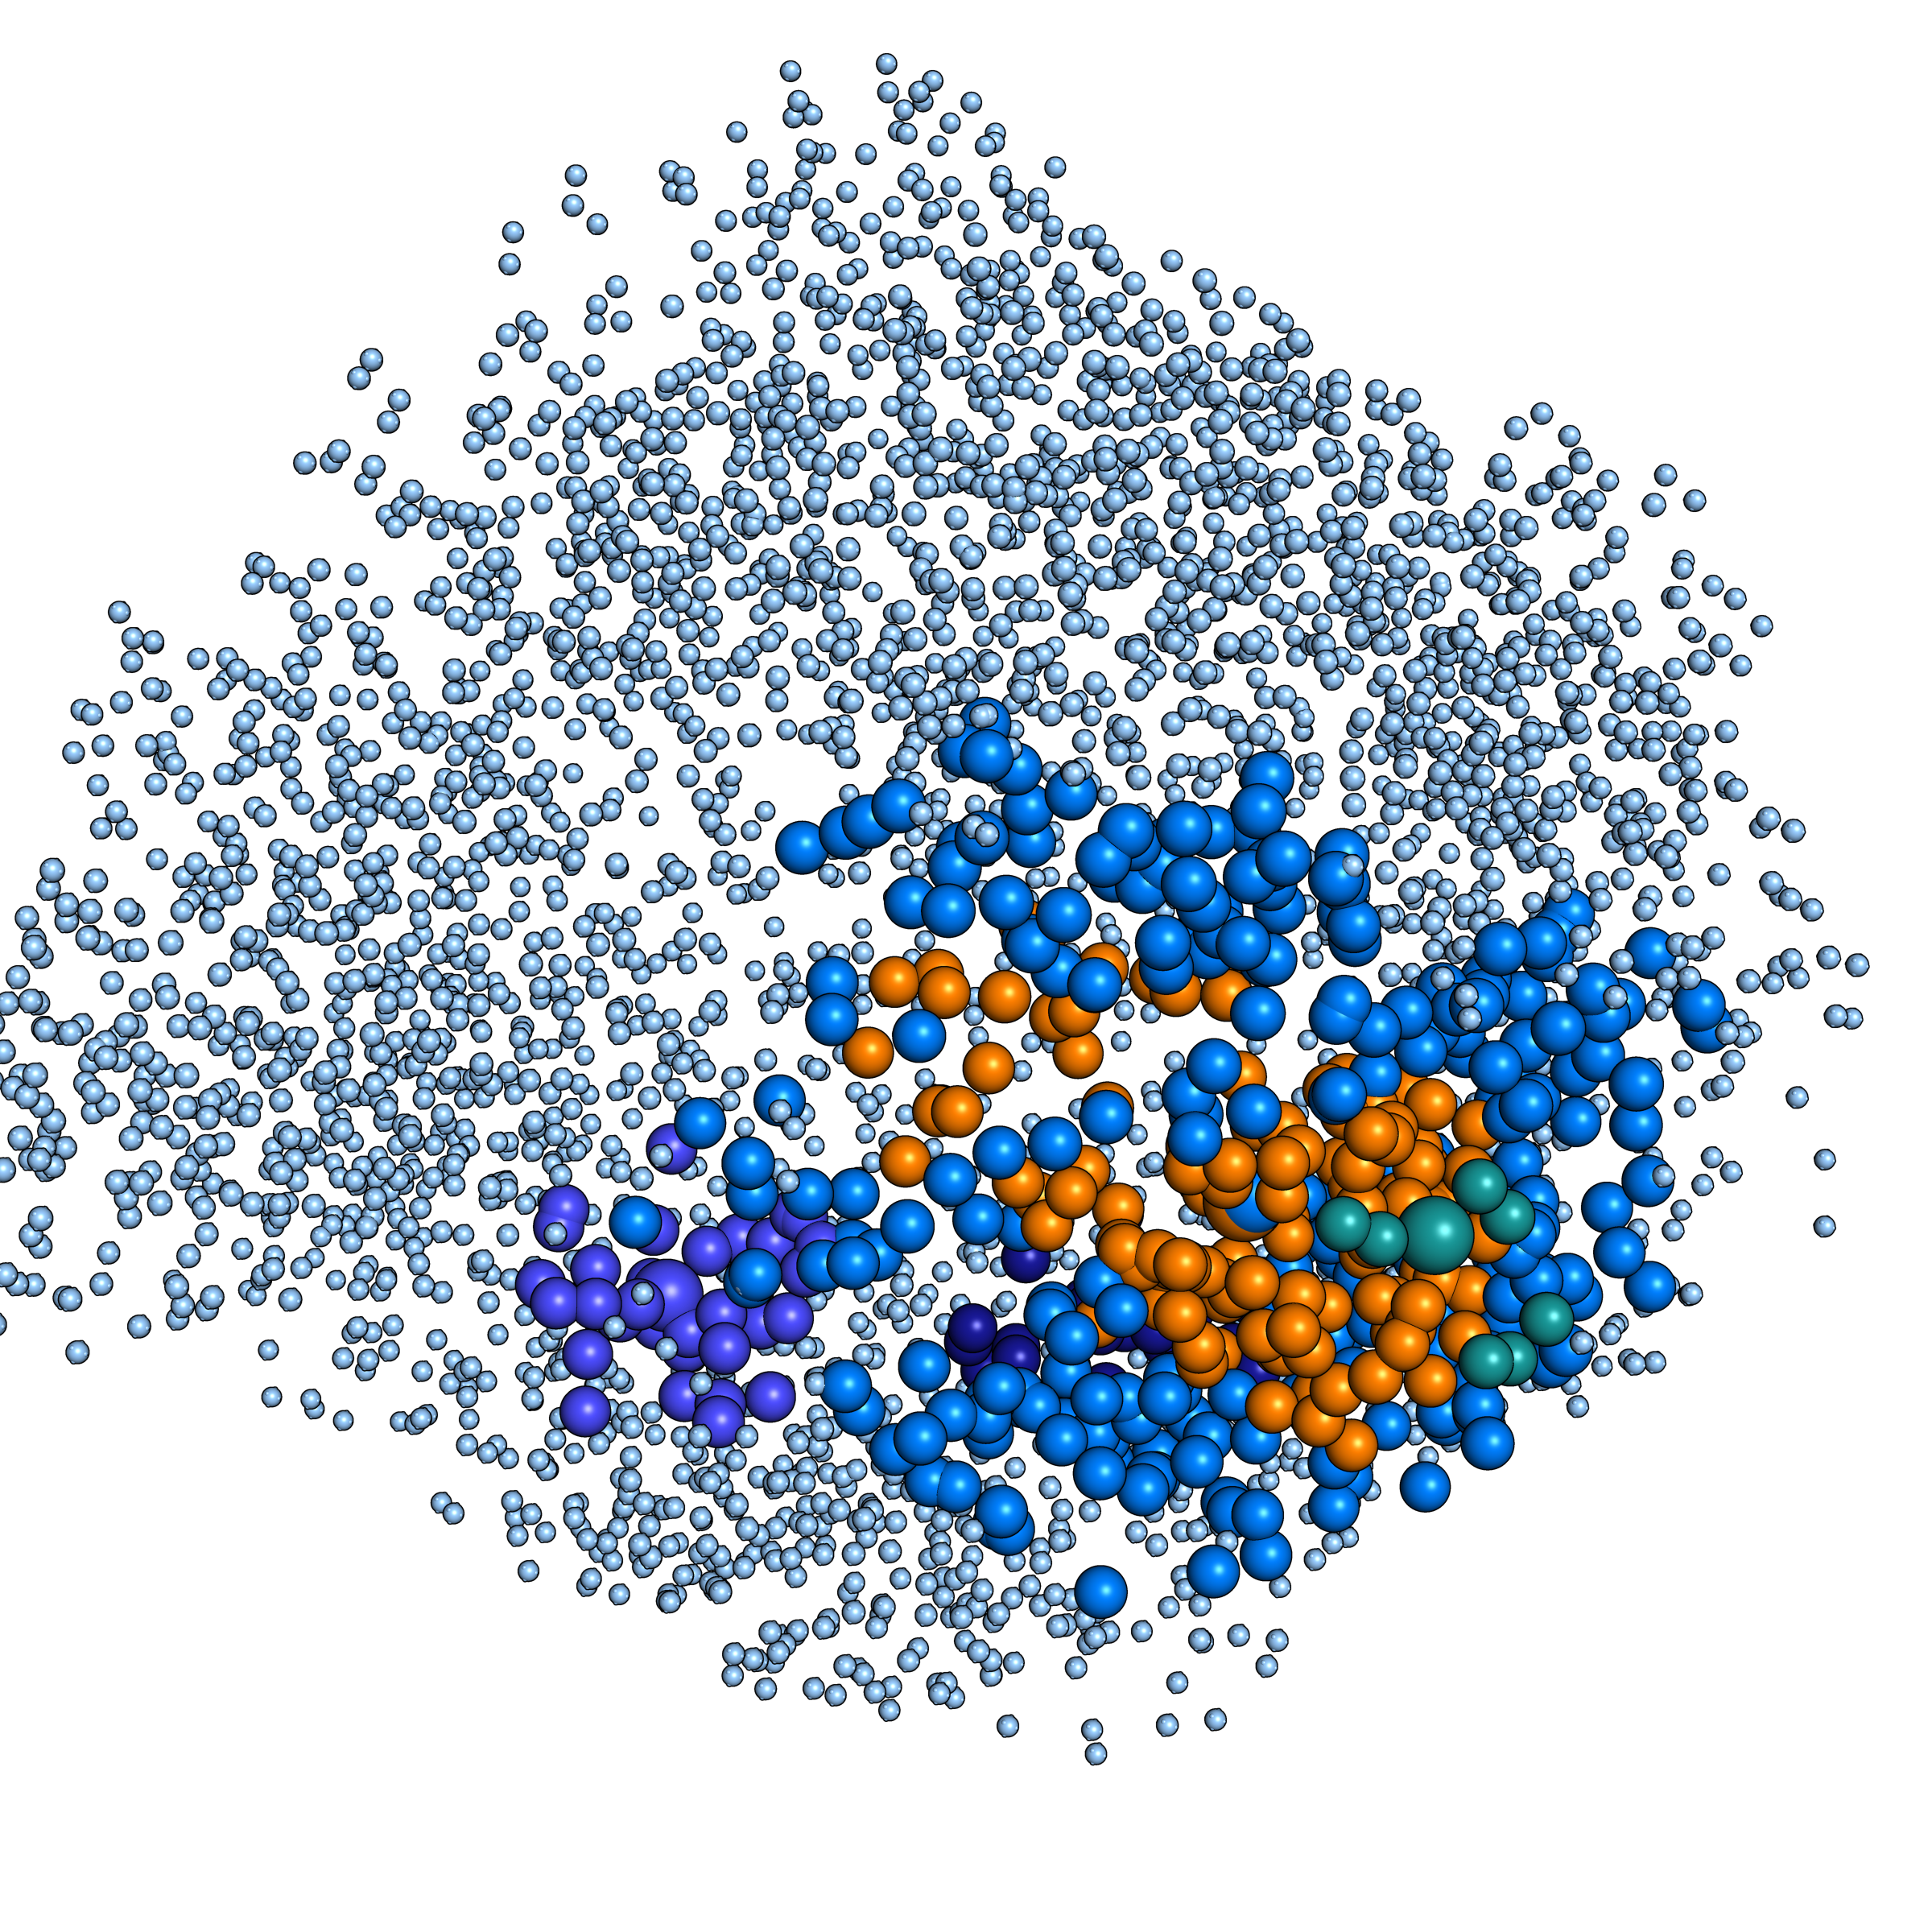


💡 TIP: Uncomment the lines above to render!
   - Set ray_trace=True for publication quality (slower, ~30-60s per protein)
   - Set ray_trace=False for quick preview (faster, ~5-10s per protein)

📝 Output files will be saved as:
   - pocket_case_study_success_styled.png
   - pocket_case_study_moderate_styled.png
   - pocket_case_study_failure_styled.png


In [15]:
# === RENDER YOUR THESIS PROTEINS ===
# Uncomment the ones you want to render:

# 1. Success case - high IoU
quick_render_for_thesis('1cge_A', 'success', ray_trace=True)

# 2. Moderate case - medium IoU  
# quick_render_for_thesis('1a4j_H', 'moderate', ray_trace=True)

# 3. Failure case - low IoU
# quick_render_for_thesis('1acj_A', 'failure', ray_trace=True)

print("\n💡 TIP: Uncomment the lines above to render!")
print("   - Set ray_trace=True for publication quality (slower, ~30-60s per protein)")
print("   - Set ray_trace=False for quick preview (faster, ~5-10s per protein)")
print("\n📝 Output files will be saved as:")
print("   - pocket_case_study_success_styled.png")
print("   - pocket_case_study_moderate_styled.png")
print("   - pocket_case_study_failure_styled.png")

## Figure Description Generator

Generate LaTeX-ready captions for thesis figures explaining the visualization elements.

In [16]:
def generate_figure_description(protein_id: str, metrics_df: pd.DataFrame, 
                                include_metrics: bool = True,
                                save_to_file: bool = True,
                                output_dir: str = "./thesis_figures") -> str:
    """
    Generate descriptive text for figure captions explaining visualization elements.
    
    Parameters:
    -----------
    protein_id : str
        PDB ID and chain (e.g., '1cge_A')
    metrics_df : pd.DataFrame
        Metrics dataframe with protein information
    include_metrics : bool
        Whether to include IoU and pocket count metrics
    save_to_file : bool
        Whether to save description to text file
    output_dir : str
        Directory to save description file
        
    Returns:
    --------
    str : Formatted figure description text
    """
    # Get protein metrics
    protein_metrics = metrics_df[metrics_df['protein_id'] == protein_id]
    
    if protein_metrics.empty:
        raise ValueError(f"Protein {protein_id} not found in metrics")
    
    iou = protein_metrics['max_iou'].values[0]
    n_gt_pockets = protein_metrics['n_gt_pockets'].values[0]
    n_pred_clusters = protein_metrics['n_pred_clusters'].values[0]
    
    # Generate description text
    description_parts = []
    
    # Main visualization explanation
    description_parts.append(
        f"Visualization of binding pocket predictions for protein {protein_id}. "
    )
    
    description_parts.append(
        "\\textbf{Visual elements:} "
        "Light blue spheres represent solvent-accessible surface (SAS) points, "
        "showing the exposed protein surface. "
        "The gray cartoon and transparent surface depict the protein structure backbone. "
        "Dark green spheres indicate ground truth binding pocket residues (from experimental data), "
        "while bright yellow spheres show predicted binding pocket residues from the model. "
    )
    
    # Add metrics if requested
    if include_metrics:
        description_parts.append(
            f"\\textbf{{Performance:}} "
            f"This protein has {int(n_gt_pockets)} ground truth pocket(s) "
            f"and {int(n_pred_clusters)} predicted cluster(s), "
            f"achieving an IoU of {iou:.3f} (Intersection over Union). "
        )
    
    # Add transparency explanation
    description_parts.append(
        "Transparency levels allow visualization of overlapping pocket regions "
        "and the relationship between surface accessibility and binding site locations."
    )
    
    full_description = "".join(description_parts)
    
    # Save to file if requested
    if save_to_file:
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True)
        
        description_file = output_path / f"{protein_id}_description.txt"
        with open(description_file, 'w') as f:
            f.write(full_description)
        
        print(f"Description saved to: {description_file}")
    
    return full_description


def quick_description(protein_id: str, category_name: str = "selected") -> str:
    """
    Quickly generate description for a protein.
    
    Parameters:
    -----------
    protein_id : str
        PDB ID and chain (e.g., '1cge_A')
    category_name : str
        Category name for organizing outputs (e.g., 'success', 'moderate', 'challenging')
        
    Returns:
    --------
    str : Figure description
    """
    output_dir = f"./thesis_figures/{category_name}"
    description = generate_figure_description(
        protein_id=protein_id,
        metrics_df=metrics_df,
        include_metrics=True,
        save_to_file=True,
        output_dir=output_dir
    )
    
    print("\n" + "="*80)
    print("FIGURE DESCRIPTION:")
    print("="*80)
    print(description)
    print("="*80)
    
    return description

### Example: Generate Description

Use these functions to create LaTeX-ready descriptions for your thesis figures.

In [ ]:
# Generate description for a protein
# quick_description('1cge_A', 'success')

# Or generate for multiple proteins at once
# for protein_id in ['1cge_A', '1x8x_A', '1a28_A']:
#     desc = quick_description(protein_id, 'top_performers')
#     print()

NameError: name 'metrics_df' is not defined

### Complete Workflow: Render + Description

Combine rendering with automatic description generation for complete thesis figures.

In [ ]:
# Complete workflow: render image + generate description
protein_id = '1cge_A'
category = 'success'

# Step 1: Render the protein with enhanced visibility
# quick_render_for_thesis(protein_id, category, ray_trace=True)

# Step 2: Generate the figure description
# description = quick_description(protein_id, category)

# Now you have:
# - High-quality PNG in ./thesis_figures/{category}/{protein_id}_practical_work_style.png
# - LaTeX-ready description in ./thesis_figures/{category}/{protein_id}_description.txt

NameError: name 'metrics_df' is not defined